# **Bernoulli vs. 3d**

A short comparison of different modeling techniques of a simple console. The beam has a rectangular prismatic cross-section and a linear elastic material model, governed by the following parameters:

In [68]:
import numpy as np

L = 100.  # length of the console
F = -100.  # value of the vertical load at the free end
E = 210000.0  # Young's modulus
nu = 0.3  # Poisson's ratio


In [69]:
from sigmaepsilon import BeamSection, get_section

section = get_section('CHS', D=10.0, t=1.0, n=64)
beam = BeamSection(wrap=section)
beam.calculate_geometric_properties()
props = beam.geometric_properties
A = props['A']
Iy = props['Iy']
Iz = props['Iz']
Ix = props['Ix']


# 1d Solution - Exact Analytical

Analytic solution for the tip displacement of an 1d Euler-Bernoulli beam:

In [70]:
# Bernoulli solution
EI = E * Iy
sol_exact = F * L**3 / (3 * EI)
tol = np.abs(sol_exact / 1000)
sol_exact


-0.5494633275573824

# 1d Solution - Approximate Numerical

In [71]:
nElem = 20  # number of finite elements to use


In [72]:
from sigmaepsilon import Structure, LineMesh, PointData
from sigmaepsilon.math.linalg import linspace, Vector
from sigmaepsilon.mesh.space import StandardFrame, PointCloud, frames_of_lines
from sigmaepsilon.fem.cells import B2 as Beam

import numpy as np
from numpy import pi as PI


# model stiffness matrix
G = E / (2 * (1 + nu))
Hooke = np.array([
    [E*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, E*Iy, 0],
    [0, 0, 0, E*Iz]
])

# space
GlobalFrame = StandardFrame(dim=3)

# mesh
p0 = np.array([0., 0., 0.])
p1 = np.array([L, 0., 0.])
coords = linspace(p0, p1, nElem+1)
coords = PointCloud(coords, frame=GlobalFrame).show()
topo = np.zeros((nElem, 2), dtype=int)
topo[:, 0] = np.arange(nElem)
topo[:, 1] = np.arange(nElem) + 1

# support at the leftmost, load at the rightmost node
loads = np.zeros((coords.shape[0], 6))
fixity = np.zeros((coords.shape[0], 6)).astype(bool)
global_load_vector = Vector([0., 0, F], frame=GlobalFrame).show()
loads[-1, :3] = global_load_vector
fixity[0, :] = True

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = frames_of_lines(coords, topo)
cd = Beam(topo=topo, frames=frames)

# set up mesh and structure
mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh)
structure.linsolve()

# postproc
# 1) displace the mesh
dofsol = structure.nodal_dof_solution()[:, :3]
local_dof_solution = dofsol[-1, :3]
sol_fem_1d_B2 = local_dof_solution[2]
sol_fem_1d_B2

-0.549464327653727

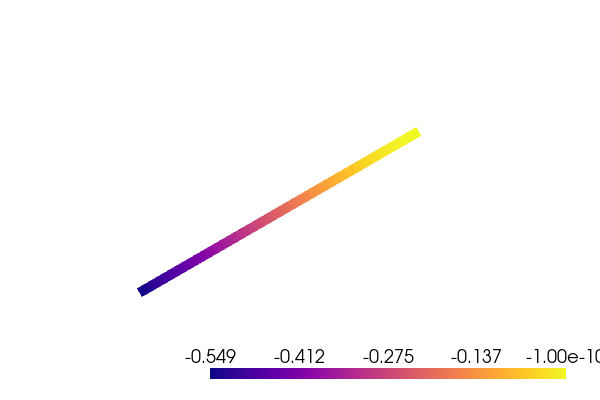

In [73]:
mesh.config['pyvista', 'plot', 'scalars'] = dofsol[:, 2]
mesh.config['pyvista', 'plot', 'line_width'] = 10
mesh.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
            config_key=('pyvista', 'plot'), cmap='plasma')

# 3d Solution

In [74]:
from sigmaepsilon import Structure, PointData, FemMesh
from sigmaepsilon.mesh.space import StandardFrame
from sigmaepsilon.fem.cells import TET4 as Cell
from dewloosh.math.array import repeat
import numpy as np

beam = BeamSection(wrap=section)
GlobalFrame = StandardFrame(dim=3)
mesh3d = beam.trimesh(frame=GlobalFrame, newaxis=0).extrude(h=L, N=120)

coords, topo = mesh3d.coords(), mesh3d.topology()

A = np.array([
    [1, nu, nu, 0, 0, 0],
    [nu, 1, nu, 0, 0, 0],
    [nu, nu, 1, 0, 0, 0],
    [0., 0, 0, (1-nu)/2, 0, 0],
    [0., 0, 0, 0, (1-nu)/2, 0],
    [0., 0, 0, 0, 0, (1-nu)/2]]) * (E / (1-nu**2))

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, 3:] = True

# unit vertical load at (Lx, Ly)
cond = (coords[:, 0] > (L-(1e-12)))
nbcinds = np.where(cond)[0][0]
loads = np.zeros((coords.shape[0], 6))
loads[nbcinds, 2] = F

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = Cell(topo=topo, frames=frames)

# set up mesh and structure
mesh = FemMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)

structure.linsolve()
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata['x'] = coords + dofsol[:, :3]
sol_fem_3d = dofsol[:, 2].min()


In [75]:
sol_fem_3d, sol_fem_1d_B2, sol_exact


(-0.5862944040864626, -0.549464327653727, -0.5494633275573824)

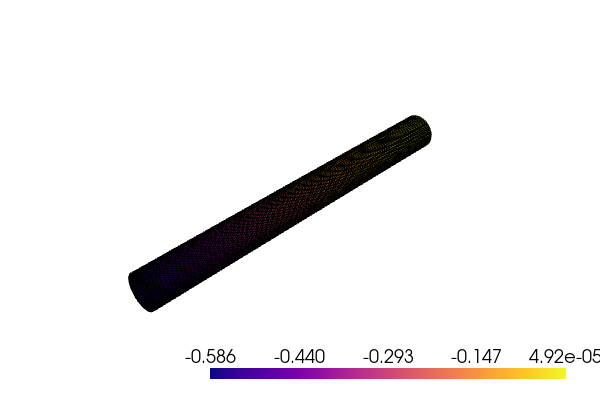

In [76]:
mesh.config['pyvista', 'plot', 'scalars'] = dofsol[:, 2]
mesh.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
            config_key=('pyvista', 'plot'), cmap='plasma')

In [77]:
from pyvistaqt import BackgroundPlotter
plotter = BackgroundPlotter()
mesh.pvplot(plotter=plotter)
plotter.show()

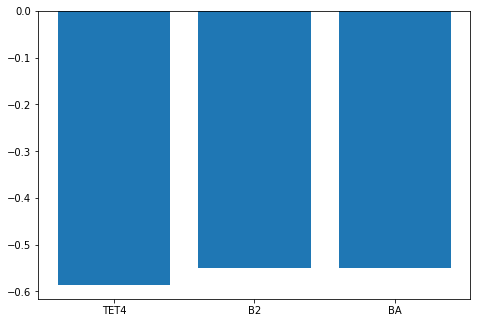

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
labels = ['TET4', 'B2', 'BA']
values = [sol_fem_3d, sol_fem_1d_B2, sol_exact]
ax.bar(labels, values)
plt.show()
